## What cloud is it?

In [1]:
#Kaggle requires phone verification to use the internet or a GPU. I had trouble with this for a bit.
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# Making sure I'm running the latest version of any libraries I need.
# It'll spit out some errors, I can run this
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search #upgrades to the latest version of fastai and ddgsearch

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-transform 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.


The basic steps we'll take are:

1. Use DuckDuckGo to search for images of different types of clouds
1. Fine-tune a pretrained neural network to classify between the different clouds.
1. Try running this model on a picture of a cloud and see if it works.

## Step 1: Download images of clouds

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

#define a function that lets us search for images from DuckDuckGo
def search_images(term, max_images=30): #find us 30 images of "term"
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image') #categorize
    #returns a list!

Let's start by searching for some cloud photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [4]:
#NB: Anything that depends on an API could fail, resulting in a JSON error. Just run it again if that's the case.
urls = search_images('"cumulus" cloud photo -cumulonimbus', max_images=1)
urls[0] #remember that search_image returns a list, so this is needed.

Searching for '"cumulus" cloud photo -cumulonimbus'


/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'http://upload.wikimedia.org/wikipedia/commons/8/8d/Cumulus_clouds_Montenegro.jpg'

...and then download a URL and take a look at it:

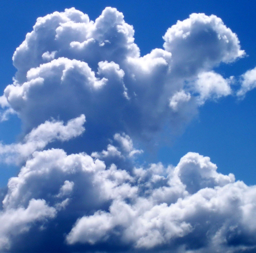

In [5]:
from fastdownload import download_url
dest = 'cumulus.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256) #notice this is on purpose. deep learning models need everything to be the same resolution

Now let's do the same with a different kind of cloud:

Searching for '"stratus" cloud photo'


/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


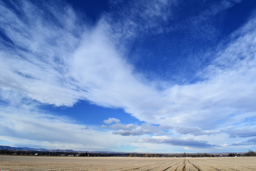

In [6]:
download_url(search_images('"stratus" cloud photo', max_images=1)[0], 'stratus.jpg', show_progress=False)
Image.open('stratus.jpg').to_thumb(256,256) #shorthand notation

Our searches seem to be working, so let's grab a few examples of photos for each type of cloud, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [7]:
searches = 'cirrus','cumulus','nimbostratus','stratus' #as classified by the NOAA.
path = Path('cloud_type')
from time import sleep

for o in searches:
    dest = (path/o) #set destination
    dest.mkdir(exist_ok=True, parents=True) #make new directory
    download_images(dest, urls=search_images(f'{o} cloud photo')) #download!
    sleep(10)  # Pause between searches to avoid over-loading server (or face getting rate-limited)
    download_images(dest, urls=search_images(f'{o} cloud sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} cloud dark photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'cirrus cloud photo'
Searching for 'cirrus cloud sun photo'
Searching for 'cirrus cloud dark photo'
Searching for 'cumulus cloud photo'
Searching for 'cumulus cloud sun photo'
Searching for 'cumulus cloud dark photo'
Searching for 'nimbostratus cloud photo'
Searching for 'nimbostratus cloud sun photo'
Searching for 'nimbostratus cloud dark photo'
Searching for 'stratus cloud photo'
Searching for 'stratus cloud sun photo'
Searching for 'stratus cloud dark photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [8]:
failed = verify_images(get_image_files(path)) #another helpful fastai function!
failed.map(Path.unlink) #remove
len(failed)

9

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

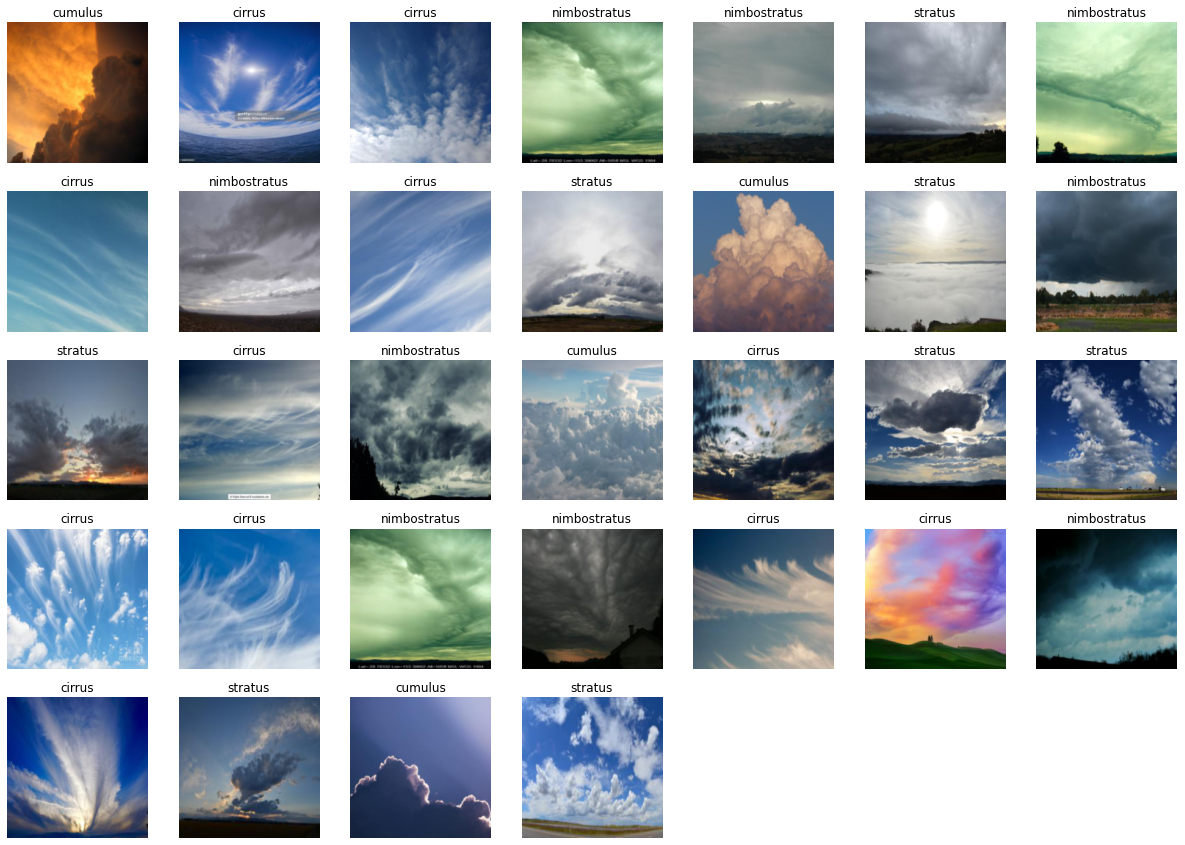

In [9]:
dls = DataBlock( #how am i gonna get data into my model?
    blocks=(ImageBlock, CategoryBlock), #what kind of input do we have (imageblock), and what kind of output (category)
    get_items=get_image_files, #get_image_files is a function. these are our verified images!
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #you need to set aside some data for validation
    get_y=parent_label,#how do we know the correct label of a photo? a.k.a. what's the answer, cumulus or....
    item_tfms=[Resize(192, method='squish')] #everything needs to be the same size, 192x192. this squishes it.
).dataloaders(path, bs=32) #pytorch iterates through dataloaders into a GPU with massive parallelism. called "batches"

dls.show_batch(max_n=36) #here's an example of a batch!

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [10]:
# learners combine the model and the data we train it with
learn = vision_learner(dls, resnet18, metrics=[error_rate, accuracy]) #dls is data, resnet18 is model.
learn.fine_tune(10) #teaching the model the differences between your dataset, and what it was originally intended for

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.880337,0.973619,0.388060,0.611940,00:08


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.838619,0.664160,0.253731,0.746269,00:02
1,0.644171,0.608574,0.238806,0.761194,00:01
2,0.470311,0.637400,0.223881,0.776119,00:02
3,0.347089,0.669252,0.179104,0.820895,00:01
4,0.265913,0.671692,0.179104,0.820895,00:01
5,0.212180,0.725436,0.179104,0.820895,00:01
6,0.171219,0.731542,0.179104,0.820895,00:01
7,0.140463,0.745631,0.194030,0.805970,00:02
8,0.116233,0.750168,0.194030,0.805970,00:01
9,0.096501,0.741950,0.194030,0.805970,00:02


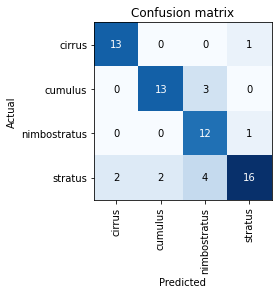

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
#let's plot a confusion matrix to investigate the error rate!

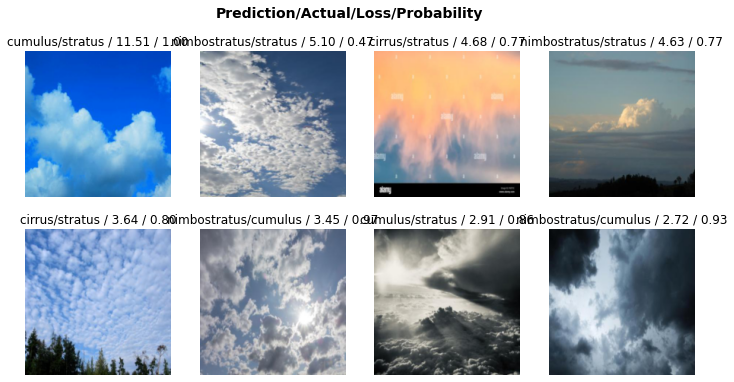

In [12]:
interp.plot_top_losses(8, nrows=2) #here are our most critical failures

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories)

## Step 3: Use our model

Let's see what our model thinks about that cloud we downloaded at the start:

Searching for 'cirrus clouds over a desert'


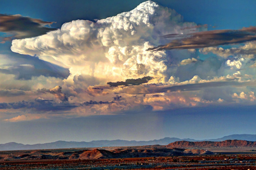

In [13]:
urls = search_images('cirrus clouds over a desert', max_images=20)
urls[8]
dest = 'exampletest.jpg'
download_url(urls[8], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

In [14]:
is_cloud,_,probs = learn.predict(PILImage.create('exampletest.jpg')) #returning the model's prediction!
print(f"This is a: {is_cloud}.")

i = 0
for o in searches:
    print(f"Probability it's a {o} cloud: {probs[i]:.4f}")
    i += 1

This is a: stratus.
Probability it's a cirrus cloud: 0.0038
Probability it's a cumulus cloud: 0.1565
Probability it's a nimbostratus cloud: 0.1038
Probability it's a stratus cloud: 0.7359


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

In [15]:
git clone https://huggingface.co/spaces/jgabemilliron/cloudproject

import gradio as gr

def greet(name):
    return "Hello " + name + "!!"

iface = gr.Interface(fn=greet, inputs="text", outputs="text")
iface.launch()

ModuleNotFoundError: No module named 'gradio'